In [ ]:
#References
#https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
#https://pasaentuciudad.com.mx/data-to-model-to-api-an-end-to-end-approach/
#https://github.com/The-AI-Summer/Deep-Learning-In-Production/tree/master/2.%20Writing%20Deep%20Learning%20code:%20Best%20Practises

# Install and import the necessary dependencies

In [ ]:

from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive')

#Create a symbolic link, in order no to be able to save weights on drive. Otherwise it gives an error. 
!ln -s /content/drive/My\ Drive /content/mydrive


#Install requirements
%cd mydrive/SentimentAnalysis
!pip install -r requirements.txt 


import os
import sys
import requests, zipfile, io

import pandas as pd
import re

import wordninja, contractions, emoji #preprocessing.py

import seaborn as sns #visualization.py
import nltk #visualization.py
from nltk.corpus import stopwords #visualization.py

import tensorflow as tf

from sklearn.model_selection import train_test_split

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/utils')
import Config

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader, datacleaner

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/models/')
import BaseModel,LSTM

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/configs')
import config_main


# Load data

In [7]:
input_path = os.path.join(config_main.CFG['data']['base_path'], 
                          config_main.CFG['data']['name'])

#Download and unzip dataset
if not (os.path.isfile(config_main.CFG['data']['url'].split('/')[-1])):
  dataloader.download_dataset_from_url(config_main.CFG['data']['url'])
dataloader.unzip_data_to_folder(input_path, config_main.CFG['data']['url'].split('/')[-1])

#Read unzipped data
print("Reading training data...")
train_data_df = pd.read_csv(os.path.join(input_path, 'training.1600000.processed.noemoticon.csv'),  
                            encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

print("Reading testing data...")
test_data_df = pd.read_csv(os.path.join(input_path, 'testdata.manual.2009.06.14.csv'),  
                           encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

#Print dataset info
print(train_data_df.info())


Directory already existed :  /content/mydrive/SentimentAnalysis/datasets/Sentiment140
Reading training data...
Reading testing data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


# Preprocess data

In [ ]:
# Preprocessing tweets data
print("Cleaning and parsing the tweets from training data...")
train_data_df = train_data_df.iloc[0:1000000] #TO-DO: Remove
train_data_df.tweet = train_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

# Preprocessing labels to have classes 0 and 1
train_data_df.sentiment = train_data_df.sentiment.apply(lambda value: 1 if value==4 
                                                        else value)

print("Sentiment values: ")
print(train_data_df.sentiment.value_counts())

print(train_data_df.head(5))



# Preprocessing tweets data
print("\nCleaning and parsing the tweets from testing data...")
test_data_df = test_data_df.iloc[0:1000] #TO-DO: Remove
test_data_df.tweet = test_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

test_data_df = test_data_df[test_data_df.sentiment!=2] #Remove intermediate polarities
test_data_df.sentiment.value_counts()/test_data_df.shape[0]

test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])


# Preprocessing labels to have classes 0 and 1
test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)


# Analyze data
Estimating the vocabulary size and the vector sequence length to be fed to the model every instance is a crucial step for a good model.

This is achieved by analyzing the training dataset, by plotting the 
distribution of tweet lengths across the training data.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Total Unique Words: 7698
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total words 64948
Total stop words 28645
Ratio of total words to total stop words: 2.267341595391866


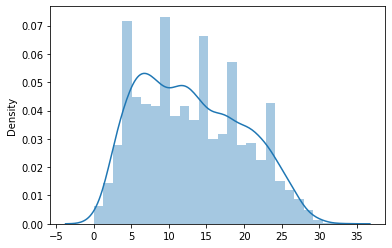

In [17]:
"""
Return the length of a tweet.
Input: tweet(str)
Output: length(int)
"""
def tweet_length(tweet):
  return len([token for token in tweet.split()])

tweet_lengths = [tweet_length(tweet) for tweet in train_data_df.tweet.tolist()]
sns.distplot(tweet_lengths)

# Unique words
unique_words = set([token for tweet in train_data_df.tweet for token in tweet.split()])
print("Total Unique Words:", len(unique_words))

# Counting Total Words and Stop Words
nltk.download("stopwords")
stop_words = stopwords.words("english")
total_words = [token for tweet in train_data_df.tweet for token in tweet.split()]
total_stop_words = [token for tweet in train_data_df.tweet for token in tweet.split() if token in stop_words]
print('Total words', len(total_words))
print('Total stop words', len(total_stop_words))
print('Ratio of total words to total stop words:', len(total_words)/len(total_stop_words))

# Train, save/serialize and evaluate the model


In [22]:
from importlib import reload  # Py3 only; unneeded in py2.
foo = reload(LSTM)

In [9]:
model = LSTM.LSTM(config_main.CFG)
model.create_train_pipeline(train_data_df)
model.data_vectorization(config_main.CFG['model']['data_vectorization']['max_features'], 
                         config_main.CFG['model']['data_vectorization']['max_len'])

model.build_model()
model.train()

model.create_test_pipeline(test_data_df)
model.test()

[1]
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 50, 128)           9600128   
                                                                 
 LSTM_1 (LSTM)               (None, 50, 256)           394240    
                                                                 
 LSTM_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                       

INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/3/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/3/assets


2/2 [==============================] - 1s 13ms/step - loss: 0.6290 - accuracy: 0.7891
